Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, cophenet
from scipy.stats import zscore
from scipy.linalg import eigh
from scipy import linalg

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

Funções para importação do base de dados e seleção as variáveis

In [2]:
PATH_TO_ENEM_CSV = "../databases/ENEM_2023_FINAL_num.csv"

def load_and_preview(path):
    df = pd.read_csv(path)
    print("Dimensões:", df.shape)
    print("Colunas:", df.columns.tolist())
    display(df.head())
    return df

def select_variables(df:pd.DataFrame, vars_list:list[str]):
    """
    Escolha as variáveis que farão parte da 'variável estatística de agrupamento'.
    (Conforme o material: selecionar variáveis relevantes; a análise é sensível a isso). :contentReference[oaicite:17]{index=17}
    """
    return df[vars_list].copy()

Detecção de outliers multivariados (Mahalanobis)

In [3]:
def mahalanobis_distance(X):
    """
    Calcula D^2 de Mahalanobis para cada observação.
    Usado nos materiais para identificar potenciais outliers multivariados. :contentReference[oaicite:18]{index=18}
    """
    X = np.asarray(X)
    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False)
    cov_inv = linalg.pinv(cov)
    dif = X - mu
    left = np.dot(dif, cov_inv)
    md2 = np.einsum('ij,ij->i', left, dif)
    return md2

def flag_outliers_md2(X, alpha=0.001):
    """
    alpha: nível para marcar outliers (usando quão grande é D2).
    Podemos usar um critério empírico (p-quantil) ou comparação com qui²(p).
    Aqui retornamos os índices ordenados por D2 decrescente.
    """
    md2 = mahalanobis_distance(X)
    df_indices = np.argsort(md2)[::-1]
    return md2, df_indices

Padronização

In [4]:
def standardize_df(df:pd.DataFrame, method="zscore"):
    """
    O material recomenda z-score quando há diferentes dispersões. :contentReference[oaicite:19]{index=19}
    """
    if method == "zscore":
        scaler = StandardScaler()
        arr = scaler.fit_transform(df.values)
        df_s = pd.DataFrame(arr, index=df.index, columns=df.columns)
        return df_s, scaler
    else:
        raise ValueError("Método de padronização não implementado")

Análise hierárquica (dendrograma) + cophenetic

In [5]:
def hierarchical_analysis(X, method="ward", metric="euclidean", plot=True):
    d = pdist(X, metric=metric)
    Z = linkage(d, method=method)
    c, coph_dists = cophenet(Z, d)  # coeficiente cofenético para avaliar dendrograma.
    if plot:
        plt.figure(figsize=(10, 5))
        dendrogram(Z, truncate_mode='level', p=30)
        plt.title(f"Dendrograma (method={method}) — coef cofenético={c:.3f}")
        plt.xlabel("Observações")
        plt.ylabel("Distância")
        plt.show()
    return Z, c

Extrair sementes a partir do corte do dendrograma

In [6]:
def seeds_from_hierarchical(Z, X, k):
    """
    Corta o dendrograma em k grupos e retorna os centróides como seeds para kmeans.
    Recomendado combinar hierárquico -> k-means (slides). :contentReference[oaicite:22]{index=22}
    """
    labels = cut_tree(Z, n_clusters=k).reshape(-1)
    seeds = []
    for lab in np.unique(labels):
        seeds.append(X[labels == lab].mean(axis=0))
    seeds = np.vstack(seeds)
    return seeds, labels

K-means (com avaliação em K)

In [7]:
def kmeans_range(X, ks=range(2,8), seeds=None, n_init=10, random_state=42):
    """
    Testa vários k, retorna: inertia, silhouette para cada k.
    (Material recomenda testar intervalo de k e avaliar). :contentReference[oaicite:23]{index=23}
    """
    results = []
    for k in ks:
        if seeds is not None and seeds.shape[0] == k:
            init = seeds
            km = KMeans(n_clusters=k, init=init, n_init=1, random_state=random_state, max_iter=300)
        else:
            km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state, max_iter=300)
        labels = km.fit_predict(X)
        inertia = km.inertia_
        sil = silhouette_score(X, labels) if k > 1 else np.nan
        results.append({'k': k, 'inertia': inertia, 'silhouette': sil, 'model': km, 'labels': labels})
    return results

def plot_k_diagnostics(results):
    ks = [r['k'] for r in results]
    inertias = [r['inertia'] for r in results]
    sils = [r['silhouette'] for r in results]
    fig, ax1 = plt.subplots(figsize=(9,4))
    ax1.plot(ks, inertias, '-o', label='Inertia (WGSS)')
    ax1.set_xlabel("k")
    ax1.set_ylabel("Inertia")
    ax2 = ax1.twinx()
    ax2.plot(ks, sils, '-s', color='tab:orange', label='Silhouette')
    ax2.set_ylabel("Silhouette score")
    ax1.set_xticks(ks)
    ax1.grid(True)
    ax1.set_title("Elbow (inertia) e Silhouette para seleção de k")
    fig.tight_layout()
    plt.show()

Perfil e interpretação

In [8]:
def cluster_profile(original_df:pd.DataFrame, cluster_labels):
    """
    Para cada cluster: contar tamanho, média das variáveis originais, e ANOVA simples (ou descriptivo).
    Material recomenda descrever centróides e interpretar características. :contentReference[oaicite:24]{index=24}
    """
    df = original_df.copy()
    df['cluster'] = cluster_labels
    profile = df.groupby('cluster').agg(['count','mean','std'])
    return profile

def plot_cluster_profiles(df_vars, labels):
    """
    Gráfico de perfis: médias padronizadas por cluster (útil para visualização). :contentReference[oaicite:25]{index=25}
    """
    df_vars = pd.DataFrame(df_vars)
    df_vars['cluster'] = labels
    centroids = df_vars.groupby('cluster').mean()
    centroids.T.plot(kind='line', marker='o', figsize=(10,5))
    plt.title("Perfil dos clusters (médias das variáveis padronizadas)")
    plt.xlabel("Variáveis")
    plt.ylabel("Média (padronizada)")
    plt.grid(True)
    plt.show()

Execução sequencial

In [9]:
def run_full_pipeline(path, variables, hier_method="ward", k_candidates=range(2,8)):
    df_all = load_and_preview(path)
    df_vars = select_variables(df_all, variables)
    md2, idx_sorted = flag_outliers_md2(df_vars.values)
    df_vars['MD2'] = md2
    print("Top 10 potenciais outliers (Mahalanobis D^2):")
    display(df_vars.sort_values('MD2', ascending=False).head(10))
    X_std, scaler = standardize_df(df_vars.drop(columns=['MD2']))
    Z, coph = hierarchical_analysis(X_std.values, method=hier_method, plot=True)
    print("Coeficiente cofenético:", coph, "(valores próximos a 0.8 são bons segundo material). :contentReference[oaicite:27]{index=27}")
    k0 = int(np.median(list(k_candidates)))
    seeds, h_labels = seeds_from_hierarchical(Z, X_std.values, k=k0)
    print(f"Usando k0={k0} clusters para gerar seeds iniciais do hierárquico.")
    # 8) kmeans range (testar com e sem seeds)
    results_no_seeds = kmeans_range(X_std.values, ks=k_candidates)
    results_with_seeds = None
    if seeds.shape[0] == k0:
        results_with_seeds = kmeans_range(X_std.values, ks=[k0], seeds=seeds)
    # 9) plot diagnósticos
    plot_k_diagnostics(results_no_seeds)
    # 10) escolher melhor k (ex.: maior silhouette ou elbow)
    best = max(results_no_seeds, key=lambda r: r['silhouette'] if not np.isnan(r['silhouette']) else -999)
    print("Melhor k por silhouette:", best['k'], "silhouette:", best['silhouette'])
    # 11) perfil e plots
    best_model = best['model']
    labels = best['labels']
    profile = cluster_profile(df_vars.drop(columns=['MD2']), labels)
    display(profile)
    plot_cluster_profiles(X_std, labels)
    # PCA 2D plot com clusters
    pca = PCA(n_components=2)
    proj = pca.fit_transform(X_std)
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=proj[:,0], y=proj[:,1], hue=labels, palette='tab10', s=40)
    plt.title(f"PCA 2D com clusters (k={best['k']})")
    plt.show()
    return {
        'df_vars': df_vars,
        'scaler': scaler,
        'hier_linkage': Z,
        'cofenetic': coph,
        'kmeans_results': results_no_seeds,
        'best': best
    }


Exemplo de execução

Dimensões: (10000, 17)
Colunas: ['TP_SEXO', 'TP_COR_RACA', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'ESCOLARIDADE_PAI', 'ESCOLARIDADE_MAE', 'INTERNET_CASA', 'EST_IDADE', 'EST_RENDA_PER_CAP', 'EST_CELULAR_PER_CAP', 'EST_COMP_PER_CAP', 'EST_VEICULO_PER_CAP', 'EST_ELE_DOM_PER_CAP']


,TP_SEXO,TP_COR_RACA,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,ESCOLARIDADE_PAI,ESCOLARIDADE_MAE,INTERNET_CASA,EST_IDADE,EST_RENDA_PER_CAP,EST_CELULAR_PER_CAP,EST_COMP_PER_CAP,EST_VEICULO_PER_CAP,EST_ELE_DOM_PER_CAP
0,Masculino,Parda,Privada,510.1,483.8,484.5,492.3,520.0,EM incompleto,ES incompleto,True,19.0,2310.002500,2.250,1.000,0.50,4.750000
1,Feminino,Branca,Estadual,583.3,474.1,564.6,599.3,660.0,EM incompleto,PG incompleto,True,18.0,1188.001000,0.900,0.400,0.00,1.800000
2,Masculino,Branca,Privada,646.5,620.7,801.6,585.7,740.0,PG completo,PG completo,True,18.0,2475.001250,0.750,1.125,0.25,1.500000
3,Feminino,Branca,Privada,553.4,495.1,605.8,554.6,880.0,PG incompleto,PG incompleto,True,17.0,2475.001250,1.125,0.500,0.25,2.625000
4,Feminino,Branca,Privada,616.3,589.7,682.8,636.7,860.0,PG incompleto,PG incompleto,True,18.0,3300.001667,1.000,1.000,0.00,1.666667


Top 10 potenciais outliers (Mahalanobis D^2):


,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,MD2
5402,0.0,480.7,553.7,622.8,480.0,144.509021
7185,0.0,524.4,665.2,566.7,800.0,137.759207
2698,0.0,482.1,517.2,0.0,360.0,128.550069
9265,0.0,449.8,504.9,0.0,360.0,123.588156
7813,617.1,0.0,765.8,648.2,940.0,123.172071
2044,0.0,540.0,550.9,529.8,740.0,121.895578
6165,0.0,589.7,573.1,378.8,840.0,107.109632
6591,0.0,480.6,525.7,464.5,580.0,98.322937
7134,0.0,381.2,478.1,468.5,640.0,94.191170
772,0.0,555.4,518.1,382.9,500.0,92.416414


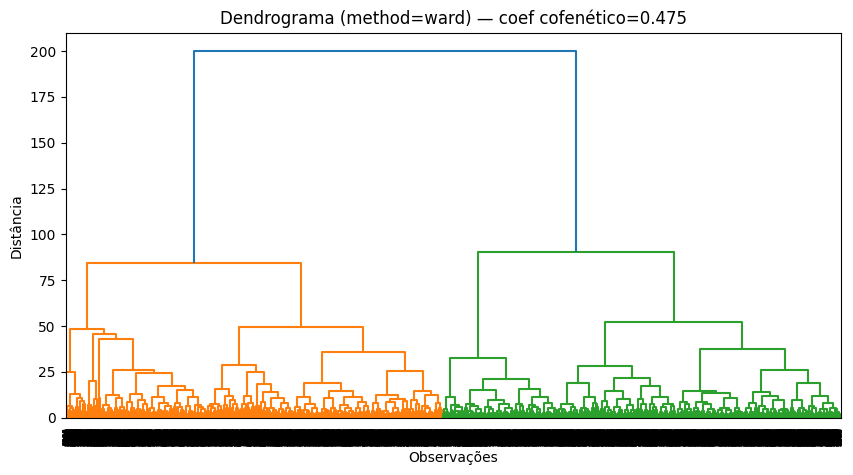

Coeficiente cofenético: 0.4746353322648735 (valores próximos a 0.8 são bons segundo material). :contentReference[oaicite:27]{index=27}
Usando k0=5 clusters para gerar seeds iniciais do hierárquico.


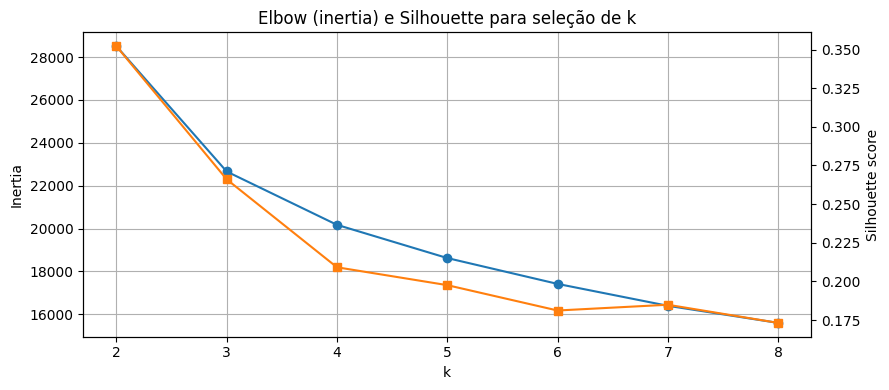

Melhor k por silhouette: 2 silhouette: 0.3521867689256877


NU_NOTA_CH                       NU_NOTA_CN                        \
             count       mean        std      count       mean        std   
cluster                                                                     
0             5000  498.21946  67.408427       5000  464.25246  66.121545   
1             5000  608.00828  46.780849       5000  577.65940  65.815259   

        NU_NOTA_MT                       NU_NOTA_LC                        \
             count       mean        std      count       mean        std   
cluster                                                                     
0             5000  500.27360  94.506537       5000  504.26500  54.429874   
1             5000  679.87162  88.955348       5000  591.88208  40.960942   

        NU_NOTA_REDACAO                       
                  count     mean         std  
cluster                                       
0                  5000  567.112  165.996296  
1                  5000  764.268  125.340042

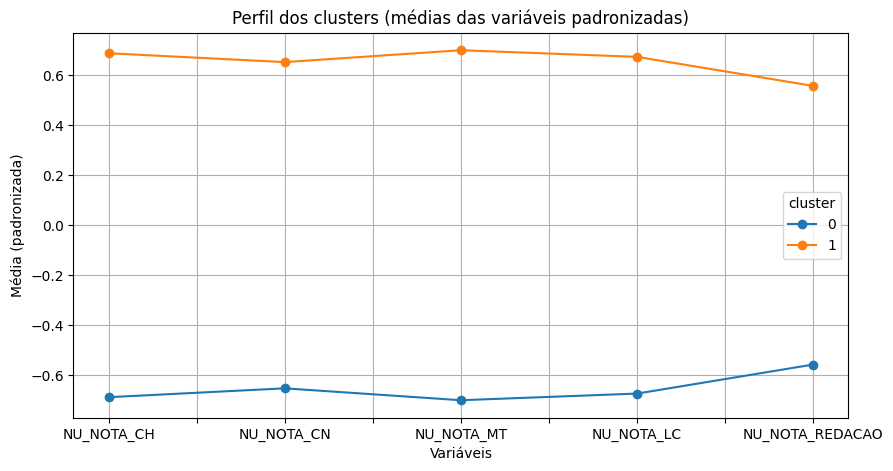

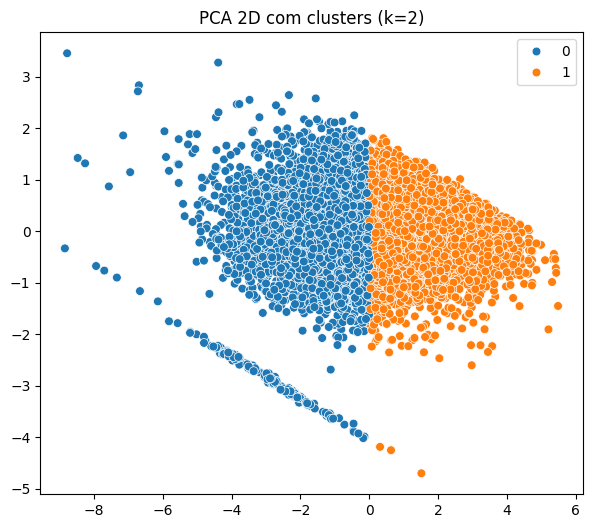

Clusters salvos em enem_2023_clusters.csv


In [13]:
vars_to_use = ['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']
out = run_full_pipeline(PATH_TO_ENEM_CSV, vars_to_use, hier_method="ward", k_candidates=range(2,9))
best_labels = out['best']['labels']
df_in = pd.read_csv(PATH_TO_ENEM_CSV)
df_in = df_in.loc[out['df_vars'].index]
df_in['cluster'] = best_labels
df_in.to_csv("enem_2023_clusters.csv", index=False)
print("Clusters salvos em enem_2023_clusters.csv")